# SCDC vs MPBP

## Module load

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [2]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions

In [3]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

sort_by_infection_time (generic function with 1 method)

## Data load

In [4]:
using JLD

data_config = load("test_data.jld")
data_beliefs_mpbp = load("beliefs_mpbp.jld");

In [11]:
T::Int = 20 # total time

G = data_config["G"]
obsmat = data_config["obsmat"]
config = data_config["config"]

beliefs_mpbp = data_beliefs_mpbp["b_bp"]

NV = nv(G)

obslist = []
for i in 1:NV
    for t in 1:T+1
        if obsmat[i, t] >= 0.0
            push!(obslist, (i, t-1))
        end
    end
end

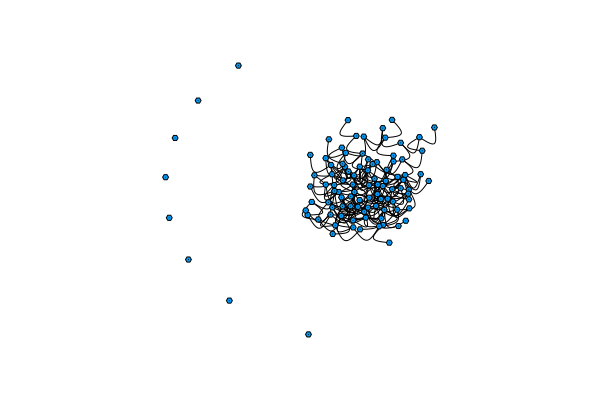

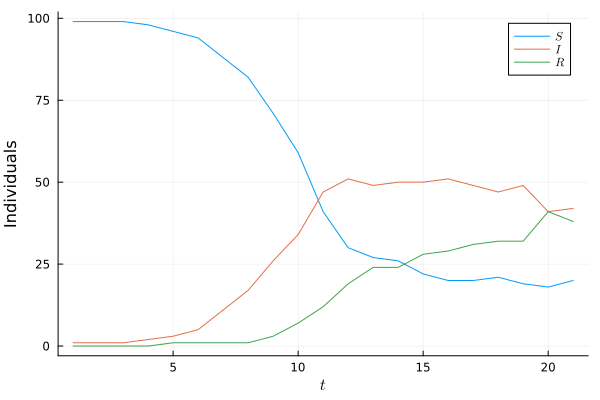

In [10]:
display(graphplot(G))

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI nrR], xlabel = L"t", ylabel = "Individuals", label = [L"S" L"I" L"R"]))

## - SIRS:

### System parameter definition

In [12]:
# define the constants
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.4 # Infection rate
r₀::Float64 = 0.15 # Recovery rate
σ₀::Float64 = 0.15 # Immunity rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIRS(ε_autoinf, r₀, σ₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ), obsmat)

# sorting
inf_tuples, invperm_sort, perm_sort = sort_by_infection_time(config, T, NV);

### Inference -- autoinfection, $\mu$ cutoff

In [13]:
# computational constants
epsconv::Float64 = 5e-15 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.0 # damping factor
μ_cutoff::Float64 = -1 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob_sorted_SCDC = zeros(NV, T+1, 3)
for inode in nodes
#    marg_prob_sorted[inode.i,:,:] .= inode.marg.m'
    marg_prob_sorted_SCDC[invperm_sort[inode.i],:,:] .= inode.marg.m'
end

marg_prob_sorted_MPBP = zeros(NV, T+1, 3)
for i in 1:NV
    marg_prob_sorted_MPBP[invperm_sort[i],:,:] .= [beliefs_mpbp[i][t][2] for t in 1:T+1]
end

 #marg_prob_sorted = marg_prob_sorted[perm_sort,:,:];

i = 1 ε = 1.1493619647193372
i = 2 ε = 1.843253188055168
i = 3 ε = 1.8132137678479907
i = 4 ε = 1.4421159498267655
i = 5 ε = 0.789918484052828
i = 6 ε = 0.42137136011196086
i = 7 ε = 0.44658876060907726
i = 8 ε = 0.5585733363946208
i = 9 ε = 0.939565415316442
i = 10 ε = 1.1893226467049414
i = 11 ε = 0.7940656551121237
i = 12 ε = 0.6216113893376936
i = 13 ε = 0.9791240861466645
i = 

14 ε = 0.32813433392504765
i = 15 ε = 0.13493062849609
i = 16 ε = 0.13605965391624253
i = 17 ε = 0.15781699990644638
i = 18 ε = 0.10327901794343564
i = 19 ε = 0.03804531257385513
i = 20 ε = 0.03683320296459469
i = 21 ε = 0.018800575266621378
i = 22 ε = 0.009599490194437399
i = 23 ε = 0.01138710984046476
i = 24 ε = 0.005112006394209223
i = 25 ε = 0.002389875269477759
i = 26 ε = 0.0029369720481240424
i = 27 ε = 0.0013395419018703558
i = 28 ε = 0.0006366379307839454
i = 29 ε = 0.000872478698413004
i = 

30 ε = 0.0003829917319678189
i = 31 ε = 0.00017658171086198937
i = 32 ε = 0.0002425422966205737
i = 33 ε = 0.00011639618631281712
i = 34 ε = 4.9004279901954106e-5
i = 35 ε = 6.818852358714267e-5
i = 36 ε = 3.407852366255071e-5
i = 37 ε = 1.3966732376080593e-5
i = 38 ε = 1.9407185667952298e-5
i = 39 ε = 1.0477354210447487e-5
i = 40 ε = 3.9738768596864205e-6
i = 41 ε = 5.42869131159307e-6
i = 42 ε = 3.2200423588646387e-6
i = 43 ε = 1.228617928450415e-6
i = 44 ε = 1.5144600593597346e-6
i = 45 ε = 9.762070326546635e-7
i = 

46 ε = 3.8369255239700806e-7
i = 47 ε = 4.1821260798879933e-7
i = 48 ε = 2.942041120723715e-7
i = 49 ε = 1.1841069263995863e-7
i = 50 ε = 1.1482212314284368e-7
i = 51 ε = 8.791738215219169e-8
i = 52 ε = 3.623421535037252e-8
i = 53 ε = 3.122194525140287e-8
i = 54 ε = 2.6121779073129403e-8
i = 55 ε = 1.0988844389991925e-8
i = 56 ε = 8.402075812874443e-9
i = 57 ε = 7.709511584685913e-9
i = 58 ε = 3.3089666007235508e-9
i = 59 ε = 2.235273077744182e-9
i = 60 ε = 2.2615650463464476e-9
i = 61 ε = 9.888150853676336e-10
i = 

62 ε = 5.864235763652914e-10
i = 63 ε = 6.595756163463307e-10
i = 64 ε = 2.9358337982898774e-10
i = 65 ε = 1.5128998054336762e-10
i = 66 ε = 1.9124490879818268e-10
i = 67 ε = 8.661693584599561e-11
i = 68 ε = 4.097400196911849e-11
i = 69 ε = 5.513178802374341e-11
i = 70 ε = 2.539918275701325e-11
i = 71 ε = 1.148947603724082e-11
i = 72 ε = 1.5798695685020903e-11
i = 73 ε = 7.404077351225169e-12
i = 74 ε = 3.201772180716489e-12
i = 75 ε = 4.501399253342697e-12
i = 76 ε = 2.1471158184738215e-12
i = 77 ε = 9.192646643896296e-13
i = 78 ε = 1.2756462552943049e-12


i = 79 ε = 6.656897255652439e-13
i = 80 ε = 2.6134649999676185e-13
i = 81 ε = 3.5627056860221273e-13
i = 82 ε = 2.0439205883349132e-13
i = 83 ε = 7.682743330406083e-14
i = 84 ε = 9.836575998178887e-14
i = 85 ε = 6.294964549624638e-14
i = 86 ε = 2.4091839634365897e-14
i = 87 ε = 2.786659791809143e-14
i = 88 ε = 2.1538326677728037e-14
i = 89 ε = 1.0380585280245214e-14
i = 90 ε = 1.0325074129013956e-14
i = 91 ε = 5.551115123125783e-15
i = 92 ε = 4.829470157119431e-15
Converged after 92 iterations


┌ Warning: backend `PGFPlotsX` is not installed.
└ @ Plots /home/tara/.julia/packages/Plots/99fPk/src/backends.jl:43


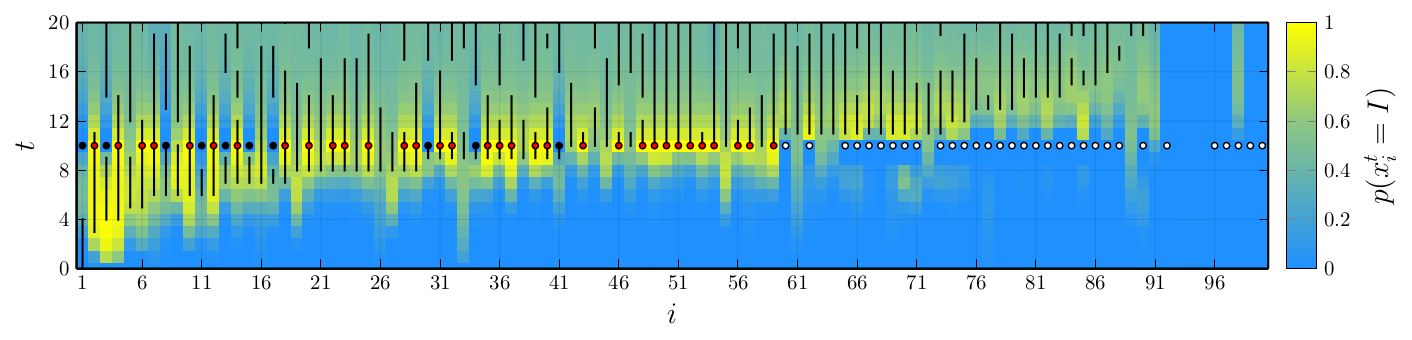

"/home/tara/julia_codes/SmallCouplingDynamicCavity/notebook/I_SCDC_autoinf_ER_k3_900x250.pdf"

In [15]:
pgfplotsx()

cols = [:white, :red, :black]
resize_factor = 1.0
cg = cgrad([:dodgerblue, :yellow], 0.6)



plI_SCDC = heatmap(1:NV, 0:T, marg_prob_sorted_SCDC[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)#, title = "Infected")

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI_SCDC, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

for (i,t) in obslist
    scatter!(plI_SCDC, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

#println("Observations at times: ", obs_times)
plot!(plI_SCDC, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)



plI_MPBP = heatmap(1:NV, 0:T, marg_prob_sorted_MPBP[:,:,2]', c=cg, xlabel="i", ylabel="t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)#, title = "Infected")

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI_MPBP, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

for (i,t) in obslist
    scatter!(plI_MPBP, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

#println("Observations at times: ", obs_times)
plot!(plI_MPBP, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

plot!(plI_SCDC, guidefontsize=14, xtickfontsize=10, ytickfontsize=10, colorbar_tickfontsize=10, colorbar_titlefontsize=14)
display(plI_SCDC)
#display(plI_MPBP)

savefig(plI_SCDC, "I_SCDC_autoinf_ER_k3_900x250.pdf")
#savefig(plI_MPBP, "I_MPBP_autoinf_ER_k3_900x250.pdf")

In [15]:
savefig(plI_SCDC, "I_SCDC_autoinf_ER_k3_900x250.pdf")

"/home/tara/julia_codes/SmallCouplingDynamicCavity/notebook/I_SCDC_autoinf_ER_k3_900x250.pdf"